**iNAP**

# Load Training Data

In [1]:
from google.colab import drive

# Set up directory to get the data files from
drive.mount('/content/drive')
datadir = "/content/drive/MyDrive/ML4FG_project/data/"

Mounted at /content/drive


In [2]:
# Import relevant libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import sequence as sequence

In [38]:
# Load train, validation and test data
df_train= pd.read_csv(datadir + "train_data.fasta", usecols=range(3), names=("ID","sequence","category"))
df_test = pd.read_csv(datadir + "test_data.fasta", usecols=range(3), names=("ID","sequence","category"))
df_val = pd.read_csv(datadir + "validation_data.fasta", usecols=range(3), names=("ID","sequence","category"))

In [39]:
# Separate input data
x_train = df_train["sequence"]
x_val = df_val["sequence"]
x_test = df_test["sequence"]

# Determine Truncation/Padding Length

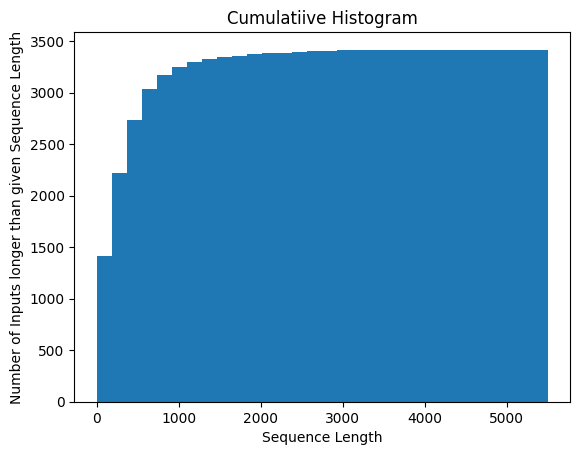

In [40]:
# See how the cumulative histogram of the input data length looks like
import matplotlib.pyplot as plt
train_seq_len = [len(x_train[i]) for i in range(len(x_train))]

plt.hist(bins=30, range=[0, 5500], cumulative=True, x=train_seq_len)
plt.xlabel("Sequence Length")
plt.ylabel("Number of Inputs longer than given Sequence Length")
plt.title("Cumulatiive Histogram")
plt.show()

In [41]:
# Select sequence length to pad/truncate the input sequence based on previous results
sequence_length = 256

In [42]:
# See how many input sequences are under or over that cutoff length
cutoff=sequence_length

num_input_over = 0
num_input_under = 0

for input_len in train_seq_len:
  if input_len > cutoff:
    num_input_over += 1
  else:
    num_input_under += 1
print("Percentage of input with length ")
print("       over " + str(cutoff) + ": " + str(num_input_over/len(x_train)))
print("       under " + str(cutoff) + ": " + str(num_input_under/len(x_train)))

Percentage of input with length 
       over 256: 0.4492541678853466
       under 256: 0.5507458321146534


# Encode input using encoding function code from ProtBERT

In [43]:
ALL_AAS = 'ALMDSNFPHUERYWTQGCVKI'
ADDITIONAL_TOKENS = ['<OTHER>', '<START>', '<END>', '<PAD>']

# Each sequence is added <START> and <END> tokens
ADDED_TOKENS_PER_SEQ = 2

n_aas = len(ALL_AAS)
aa_to_token_index = {aa: i for i, aa in enumerate(ALL_AAS)}
additional_token_to_index = {token: i + n_aas for i, token in enumerate(ADDITIONAL_TOKENS)}
token_to_index = {**aa_to_token_index, **additional_token_to_index}
index_to_token = {index: token for token, index in token_to_index.items()}
n_tokens = len(token_to_index)

# function that takes in sequence input and returns tokenized input representation
def tokenize_seq(seq):
    other_token_index = additional_token_to_index['<OTHER>']
    return [additional_token_to_index['<START>']] + [aa_to_token_index.get(aa, other_token_index) for aa in parse_seq(seq)] + \
            [additional_token_to_index['<END>']]

# function that parses sequence input
def parse_seq(seq):
    if isinstance(seq, str):
        return seq
    elif isinstance(seq, bytes):
        return seq.decode('utf8')
    else:
        raise TypeError('Unexpected sequence type: %s' % type(seq))

# Tokenize and encode dataset

In [44]:
# function to tokenize dataset
def tokenize_set(data):
  encode_list = []
  for row in data:
    encode_list.append(tokenize_seq(row))
  return encode_list

# Encode dataset
train_encode = tokenize_set(x_train)
val_encode = tokenize_set(x_val)
test_encode = tokenize_set(x_test)

In [45]:
# Apply padding/truncation to encoded data
padding_token_index = additional_token_to_index['<PAD>']
train_pad = sequence.pad_sequences(train_encode, maxlen=sequence_length, value=padding_token_index, padding='post', truncating='post')
val_pad = sequence.pad_sequences(val_encode, maxlen=sequence_length, value=padding_token_index, padding='post', truncating='post')
test_pad = sequence.pad_sequences(test_encode, maxlen=sequence_length, value=padding_token_index, padding='post', truncating='post')

print(train_pad.shape, val_pad.shape, test_pad.shape)

(3419, 256) (427, 256) (426, 256)


In [46]:
from sklearn.preprocessing import OneHotEncoder

# Create one-hot encoding for the output label
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
train_y = onehot_encoder.fit_transform(df_train[['category']]).toarray()
val_y = onehot_encoder.fit_transform(df_val[['category']]).toarray()
test_y = onehot_encoder.fit_transform(df_test[['category']]).toarray()

print(train_y)
print(train_y.shape)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
(3419, 4)


# Build the Bi-LSTM CNN Model

In [47]:
# Import necessary libraries to build the model using Keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
# There are 4 classes, representing DNA-binding, RNA-binding, DRNA-binding and None
num_of_classes = 4

# 24 words in vocab because 20 amino acids + 4 additional tokens (start, end, pad, other)
NUM_WORDS=24

dropout = 0.5
embedding_vector_length = 100

model = Sequential()

# Embedding Layer
model.add(Embedding(NUM_WORDS, embedding_vector_length, input_length=sequence_length))
model.add(Dropout(dropout))

# Convolutional Layer
model.add(Conv1D(filters=100, kernel_size=10, padding='same', activation='relu'))
model.add(Conv1D(filters=100, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(dropout))

# Bi-LSTM Layer
model.add(Bidirectional(LSTM(100, return_sequences=False, recurrent_dropout=0.5)))

model.add(Dense(num_of_classes, activation='softmax'))

# Use categorical crossentrophy loss
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(multi_label=False)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          2400      
                                                                 
 dropout (Dropout)           (None, 256, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 256, 100)          100100    
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 100)          50100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 128, 100)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128, 100)          0         
                                                        

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# define filepath where the model will be saved
filepath = "model.h5"
# define the checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Train Model

In [ ]:
hist = model.fit(train_pad, train_y, validation_data=(val_pad, val_y), epochs=50, batch_size=256, callbacks=callbacks_list)

In [ ]:
#Run if 30 epoch was not enough.
model = load_model(filepath)
new_hist = model.fit(train_pad, train_y, validation_data=(val_pad, val_y), epochs=20, batch_size=256, callbacks=callbacks_list)
hist.history['val_accuracy'] += new_hist.history['val_accuracy']
hist.history['accuracy'] += new_hist.history['accuracy']

In [ ]:
#Run if 50 epoch was not enough.
model = load_model(filepath)
new_hist = model.fit(train_pad, train_y, validation_data=(val_pad, val_y), epochs=20, batch_size=256, callbacks=callbacks_list)
hist.history['val_accuracy'] += new_hist.history['val_accuracy']
hist.history['accuracy'] += new_hist.history['accuracy']

# Print Results and Evaluate Model

In [ ]:
# Print Results
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate Model Performance
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

model.evaluate(test_pad, test_y)
y_pred = model.predict(test_pad)
auc = metrics.accuracy_score(test_y, y_pred)
print(auc)